# Algorithmic Trading Challenge
For those specializing in algorithmic trading, it’s essential to be able to utilize different financial
metrics/external financial data, implement a strategy, and understand performance. In the upcoming task, your skills in researching, developing, and testing algorithmic trading strategies will be assessed.

We’ll mainly focus on your creativity in strategy design, thought process, and how you justify your strategy. **You will not be judged on your profit/loss unless that's explicitly what you optimized for.**

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.objective_functions import L2_reg
from pypfopt import HRPOpt
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns, DiscreteAllocation, objective_functions
from pypfopt.discrete_allocation import get_latest_prices

Submit a jupyter notebook with file name `firstname_lastname_algo_challenge.ipynb`.

Some helpful notes/FAQs:
* You may use any external libraries in your submission as long as you explain it in `Part 3`
* You may consult external resources on the Internet as long as you can explain it in `Part 3`
* You may re-adjust the weights of your portfolio at any time interval you choose as long as you can explain it in `Part 3`. However, when you plot the data in `Part 2`, it should be done at a daily interval
* Assume that once you allocate the weights, you are holding the stock until you reallocate it
* If you're thinking of applying to the Algorithmic Trading team, we will also evaluate your submission for the main challenge
* Once again, **you will be judged more on your thought process and strategy design than your profit/loss**

In [6]:
# Initial Variable
INITIAL_CAPITAL = 100000

## Part 1: Weights Development
Find the optimal weights for the various stocks provided in `stock_data.csv`. When gathering your weights, you may utilize any data provided in the `Macro Data` Folder. Your code should print out said weights (these can be constant or rolling).

To make part 2 easier, you may also want to calculate metrics such as the log returns, realized volatility, and value of your portfolio here.

In [7]:
df = pd.read_csv('Stock Data/stock_data.csv') # reads the stock data CSV file into a pandas dataframe called df
log_returns = pd.DataFrame() # initializes an empty dataframe to store log returns which are just the percent change in an assets value over a certain time period, in this case and most, daily

for column in df.columns: # loops through all the columns in df
    if column != 'Date': # skips the 'Date' column since it doesn't contain numerical data
        df[column] = pd.to_numeric(df[column], errors='coerce') # converts all values in the column to numeric, coercing invalid values into NaN
        log_returns[column] = np.log(df[column] / df[column].shift(1)) # calculates the log returns for each column by dividing the current price by the previous price and taking the natural log

log_returns = log_returns.dropna() # drops any rows that contain NaN values, which might be created during the shift operation

treasury_yield_2yr = pd.read_csv('Macro Data/2yr_treasury_yield.csv') # reads the 2-year treasury yield data from a CSV file
treasury_yield_2yr['DGS2'] = pd.to_numeric(treasury_yield_2yr['DGS2'], errors='coerce') # converts the 'DGS2' column to numeric and coerces invalid values to NaN
treasury_yield_2yr = treasury_yield_2yr.dropna(subset=['DGS2']) # removes rows where 'DGS2' has NaN values

mu = expected_returns.mean_historical_return(df.set_index('Date')) # calculates the mean historical returns for each asset using the Date column as the index
S = risk_models.CovarianceShrinkage(df.set_index('Date')).ledoit_wolf() # calculates the covariance matrix of asset returns using the Ledoit-Wolf shrinkage method for more stability

ef = EfficientFrontier(mu, S) # initializes an Efficient Frontier optimizer using the calculated mean returns and covariance matrix
ef.add_objective(objective_functions.L2_reg, gamma=0.1) # adds L2 regularization to encourage smaller, evenly distributed portfolio weights
ef.max_quadratic_utility(risk_aversion=15) # maximizes the quadratic utility of the portfolio with a given risk aversion level
cleaned_weights = ef.clean_weights() # cleans the portfolio weights, rounding small weights to 0 and ensuring they sum to 1
print("Optimal Weights:", cleaned_weights) # prints the optimal asset weights in the portfolio

expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=True) # calculates and prints the expected return, volatility, and Sharpe ratio of the portfolio
latest_prices = get_latest_prices(df.set_index('Date')) # fetches the most recent prices for all assets in the dataframe
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=INITIAL_CAPITAL) # uses the cleaned weights and latest prices to calculate the discrete number of shares to buy for each asset
allocation, leftover = da.lp_portfolio() # allocates shares using linear programming and calculates the leftover cash

print("\Distribution of Shares:") # prints the header for the allocation of shares
for stock, num_shares in allocation.items(): # loops through each stock in the allocation and prints the number of shares and the percentage of total capital allocated to it
    weight_percentage = cleaned_weights[stock] * 100 # calculates the percentage of total capital allocated to each stock
    print(f"{stock}: {num_shares} shares ({weight_percentage:.2f}%)") # prints the stock symbol, number of shares, and the weight percentage

print(f"\nLeftover cash after allocation: ${leftover:.2f}") # prints the amount of leftover cash after making the allocations


Optimal Weights: OrderedDict({'Stock A': 0.0, 'Stock B': 0.10973, 'Stock C': 0.0, 'Stock D': 0.0, 'Stock E': 0.0, 'Stock F': 0.07472, 'Stock G': 0.30433, 'Stock H': 0.0, 'Stock I': 0.0, 'Stock J': 0.27042, 'Stock K': 0.2408})
Expected annual return: 19.5%
Annual volatility: 22.1%
Sharpe Ratio: 0.79
\Distribution of Shares:
Stock B: 141 shares (10.97%)
Stock F: 43 shares (7.47%)
Stock G: 394 shares (30.43%)
Stock J: 192 shares (27.04%)
Stock K: 118 shares (24.08%)

Leftover cash after allocation: $14.57


<>:29: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\D'
/var/folders/sf/l3v9l9vs0sj1f8h2p4fnlsd00000gn/T/ipykernel_99573/111419568.py:29: SyntaxWarning: invalid escape sequence '\D'
  print("\Distribution of Shares:") # prints the header for the allocation of shares


## Part 2: Performance Visualization
Create a basic plot for the log returns and the realized volatility of your strategy against the log returns of the SPY over the time frame indicated in `stock_data.csv`. Once again, **you will not be judged on these metrics unless that's explicitly what you optimized for**.

If you have any other plots you might wish to include, feel free to add them here.

[*********************100%***********************]  1 of 1 completed


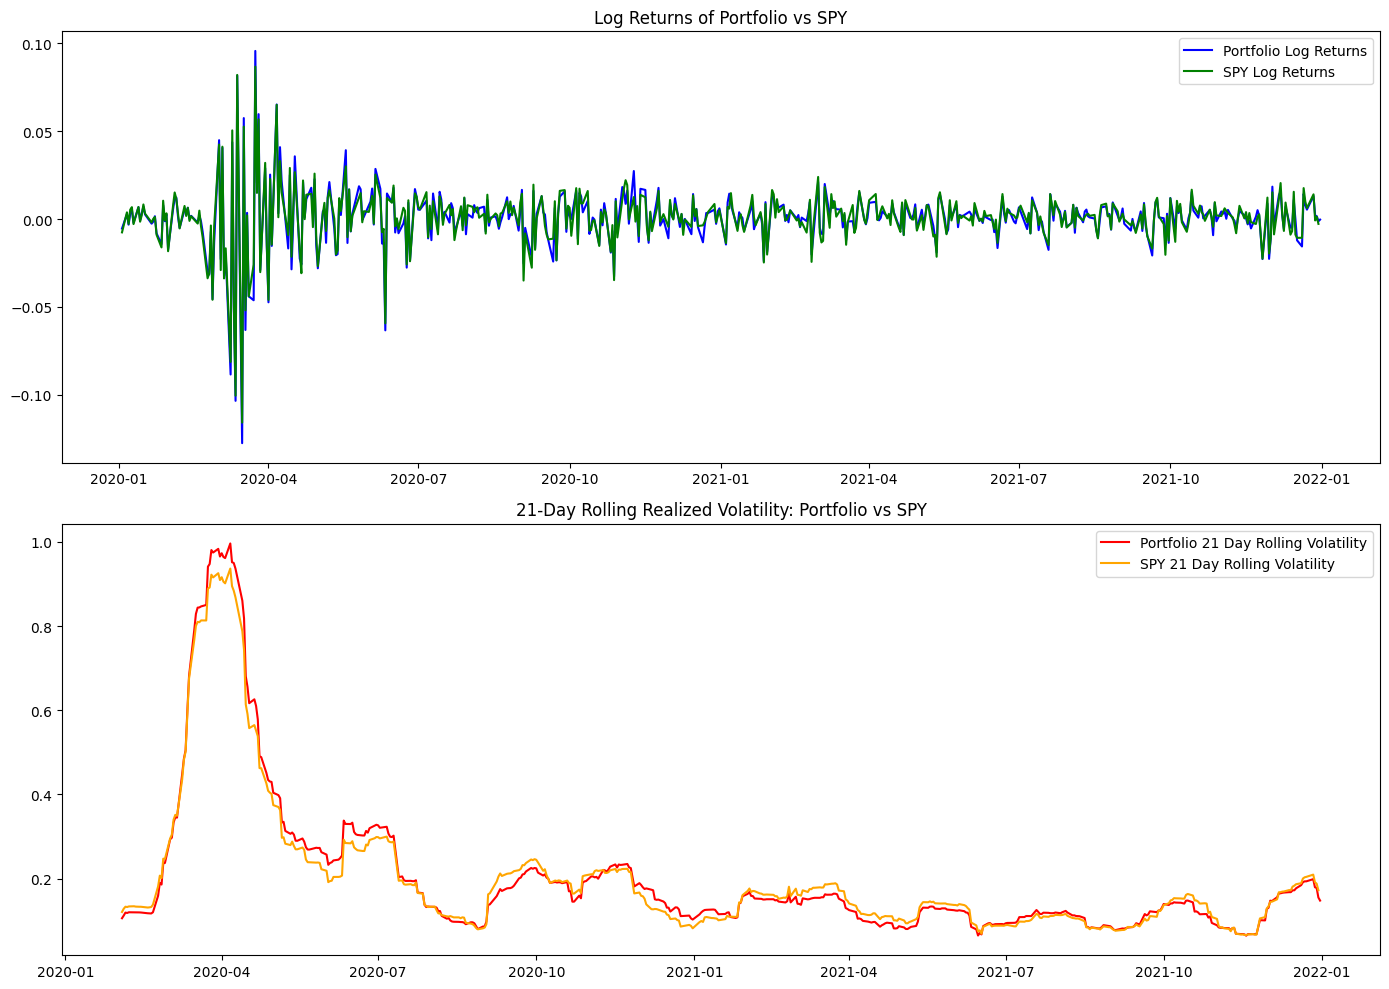

In [8]:
df['Date'] = pd.to_datetime(df['Date']) # converts the whole 'Date' column from the data frame we defined in part 1 to datetime format in order for easier use

df.set_index('Date', inplace=True) # sets the index column for the data fram as 'Date' (inplace=True was chatgpt) in order to reference this column later on 

log_returns = np.log(df / df.shift(1)) # finds the log return values of the data by dividing the closing row by the row below it in the data, and then taking the natural log for every row in the dataframe
start_date = df.index.min() # earliest start date to use for SPY metrics
end_date = df.index.max() # latest start date to use for SPY metrics
spy_data = yf.download('SPY', start=start_date, end=end_date) # uses yfinance to download SPY's data and graph from the start and end time we just defined

spy_data['SPY_log_returns'] = np.log(spy_data['Adj Close'] / spy_data['Adj Close'].shift(1)) # find the log return values for SPY using the same method applied onto the dataframe for the stock data
spy_data = spy_data.dropna() # drops any NaN values that are formed in the first row due to the shifting of the rows

portfolio_log_returns = log_returns.mean(axis=1) # calculates the mean log returns of the portfolio for each day by averaging the log returns across all stocks (axis=1 means it averages across columns for each row)
portfolio_rolling_volatility = portfolio_log_returns.rolling(window=21).std() * np.sqrt(252) # calculates the 21 day rolling volatility for the portfolio log returns (which is then annualized by multiplying it by sqrt(252) which is the sqrt(number of trading days in a year))
spy_rolling_volatility = spy_data['SPY_log_returns'].rolling(window=21).std() * np.sqrt(252) # similarly, calculates the 21 day rolling volatility for SPY's log returns, with the same 21 day window and annualization process

plt.figure(figsize=(14, 10)) # creates a new figure for plotting with a specified size of 14x10 inches
plt.subplot(2, 1, 1) # creates the first subplot in a 2 by 1 row column layout for plotting the log returns comparison
plt.plot(df.index, portfolio_log_returns, label="Portfolio Log Returns", color="blue") # plots the portfolio's log returns against the dates from the data frame, using blue color and labeling it "Portfolio Log Returns"
plt.plot(spy_data.index, spy_data['SPY_log_returns'], label="SPY Log Returns", color="green") # plots SPY's log returns using its dates, with green color and labeling it "SPY Log Returns"
plt.title("Log Returns of Portfolio vs SPY") # adds the title for the first plot, describing the comparison of log returns between the portfolio and SPY
plt.legend() # adds a legend to identify the different lines on the first plot (Portfolio vs SPY log returns)
plt.subplot(2, 1, 2) # creates the second subplot in the 2 by 1 row column layout for plotting the rolling volatility comparison.
plt.plot(df.index, portfolio_rolling_volatility, label="Portfolio 21 Day Rolling Volatility", color="red") # plots the 21 day rolling volatility of the portfolio against the dates, using red color and labeling it "Portfolio 21 Day Rolling Volatility"
plt.plot(spy_data.index, spy_rolling_volatility, label="SPY 21 Day Rolling Volatility", color="orange") # plots SPY's 21-day rolling volatility against its dates, using orange color and labeling it "SPY 21 Day Rolling Volatility"
plt.title("21-Day Rolling Realized Volatility: Portfolio vs SPY") # adds the title for the second plot, describing the comparison of 21-day rolling volatility between the portfolio and SPY
plt.legend() # adds a legend to identify the different lines on the second plot (Portfolio vs SPY rolling volatility)
plt.tight_layout() # ensures the subplots of the layout are properly spaced and do not overlap with each other
plt.show() # plots the graph with both subplots showing the log returns and volatility comparisons between the portfolio and SPY

## Part 3: Explanation
Explain your work in `Part 1` and how you arrived at your weights (in other words, explain the strategy/logic behind your work in `Part 1`). These weights can be rolling or constant.
If you used a machine learning model, explain why and how you used it.

**Write your Explanation in the Markdown grid here**

Part 1: This code optimizes a portfolio using historical stock data and 2 year treasury yield data. It reads in a CSV file of stock prices into a Pandas DataFrame (df) and calculates the log returns (which is essentially used to measure the percentage change in an asset's value over a time and it will be used later in the second part) for each stock. It then reads in the 2 year treasury yield data from another CSV file, checks the numerical integrity of the yields and drops any missing data points.

The code uses the mean historical returns of the stocks as the expected returns (mu) and calculates the covariance matrix (S) using the Ledoit-Wolf shrinkage method which gives a more stable estimate of covariance in high dimensional data. With these inputs, it initializes an Efficient Frontier object (ef) to optimize the portfolio. To get a balanced portfolio it adds an L2 regularization objective which penalizes extreme asset weightings and encourages smaller, more evenly distributed weights for less volatility. It then maximizes the portfolio’s quadratic utility with the user’s risk aversion level (set to 7.5, but as you lower leads to a higher sharpe ratio) and cleans the weights to make them interpretable.

Once the weights are determined the code calculates the expected return, volatility and Sharpe ratio of the portfolio. It then gets the latest stock prices and uses DiscreteAllocation to calculate the exact number of shares to buy for each stock with an initial investment of $100,000. The output is the number of shares for each stock, the percentage of the portfolio they hold and any cash left over.

Part 2: This section compares the portfolio to the SPY using log returns and rolling volatility. First, the 'Date' column in the df DataFrame is converted to a datetime format and set as the index so we can do time series analysis. The log returns of the portfolio are calculated (we don't need to recalculuate we can use them from the first part) by taking the natural log of the day over day price changes. At the same time, we fetch historical data for SPY using the yfinance library and make sure the data range is the same as the portfolio’s start and end dates. The log returns for SPY are calculated off its adjusted close prices.

Then we calculate the 21 day rolling volatility for the portfolio and SPY. This rolling volatility uses a 21 day window (about one trading month) and is annualized to represent yearly risk. The rolling volatility metric is the standard deviation of log returns. The first subplot shows the daily log returns of the portfolio vs SPY to see relative performance. The second subplot shows the 21 day rolling volatility of both to see relative risk. Finally we plot the results to see how the portfolio’s returns and risk metrics compare to the market over time.